### Load Dataset

In [1]:
train_dir = ./Physiological Systems/Final_project/train
test_dir = ./Physiological Systems/Final_project/test

### Data Augmentation, transformation and Normalization

On-The-Fly data augmentation was used which essentially uses randomized transofrmation on the training set. This is useful due to the small dataset used within the experiment. Applying data agumentation will increase the variation and the diversity of the training set and is computationally more efficient than off-line data agumentation

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory and apply transformations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3890 images belonging to 3 classes.
Found 948 images belonging to 3 classes.


### Model

In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load a pre-trained model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers 
x = Flatten()(base_model.output)

# First custom dense layer
x = Dense(4096, activation='relu')(x)  # Increased number of units
x = BatchNormalization()(x)             # Add batch normalization
x = Dropout(0.5)(x)                     # Maintain dropout rate

# Second custom dense layer
x = Dense(2048, activation='relu')(x)   # Additional dense layer with more units
x = BatchNormalization()(x)             # Add batch normalization
x = Dropout(0.5)(x)                     # Maintain dropout rate

# Third custom dense layer
x = Dense(1024, activation='relu')(x)   # Additional dense layer with fewer units
x = BatchNormalization()(x)             # Add batch normalization
x = Dropout(0.5)(x)                     # Maintain dropout rate

# Output layer
predictions = Dense(3, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



### Training

In [4]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10
121/121 [==============================] - 632s 5s/step - loss: 1.0767 - accuracy: 0.6426 - val_loss: 0.9610 - val_accuracy: 0.6433
Epoch 2/10
121/121 [==============================] - 635s 5s/step - loss: 0.9292 - accuracy: 0.7006 - val_loss: 0.9823 - val_accuracy: 0.6907
Epoch 3/10
121/121 [==============================] - 639s 5s/step - loss: 0.8660 - accuracy: 0.7322 - val_loss: 0.6922 - val_accuracy: 0.8136
Epoch 4/10
121/121 [==============================] - 640s 5s/step - loss: 0.7645 - accuracy: 0.7385 - val_loss: 0.6766 - val_accuracy: 0.8179
Epoch 5/10
121/121 [==============================] - 640s 5s/step - loss: 0.7344 - accuracy: 0.7499 - val_loss: 0.7078 - val_accuracy: 0.8039
Epoch 6/10
121/121 [==============================] - 642s 5s/step - loss: 0.6575 - accuracy: 0.7771 - val_loss: 1.0761 - val_accuracy: 0.7694
Epoch 7/10
121/121 [==============================] - 640s 5s/step - loss: 0.6920 - accuracy: 0.7626 - val_loss: 0.7138 - val_accuracy: 0.8190

### Evaluation

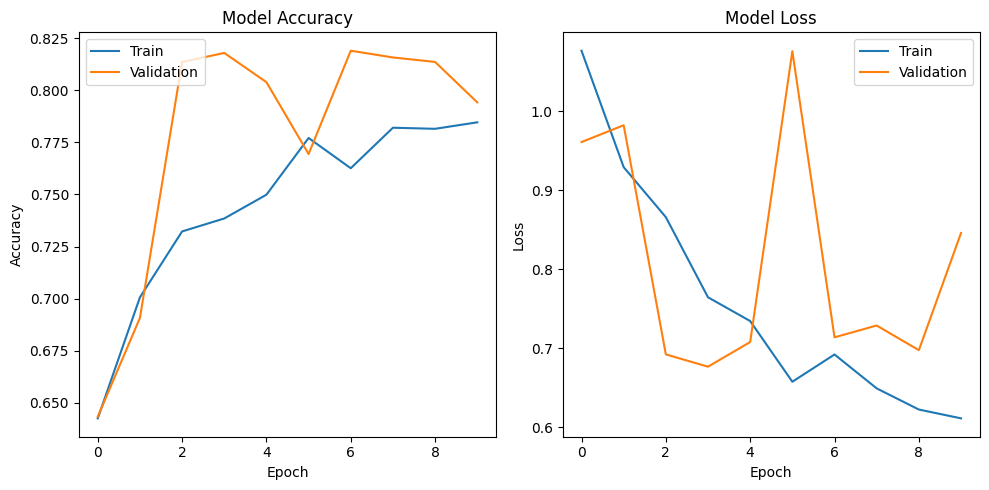

In [5]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

30/30 [==============================] - 119s 4s/step


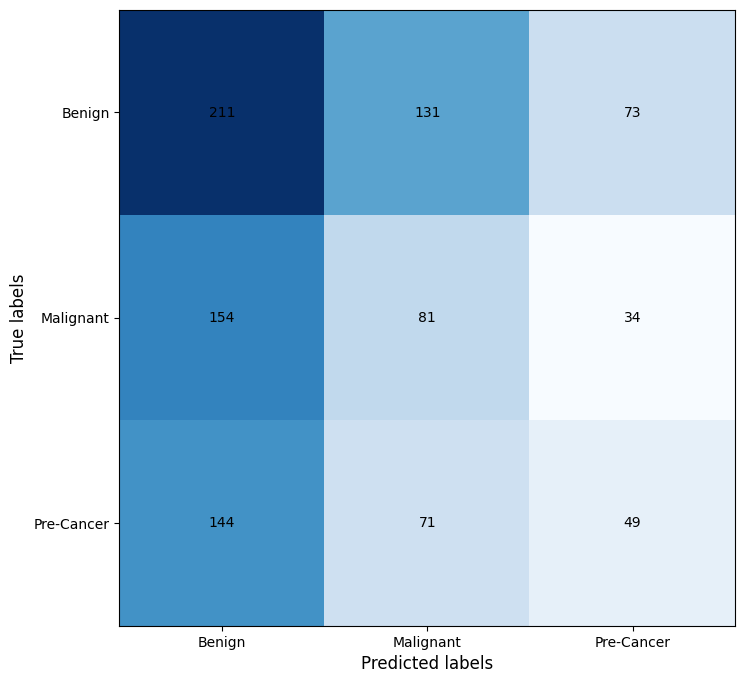

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels 
y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.xaxis.set_ticklabels(['Benign', 'Malignant', 'Pre-Cancer'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant', 'Pre-Cancer'])

# Add labels to each cell
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()
